## Residual network

In [1]:

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, BatchNormalization, Conv2D, Dense, Flatten, Add
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt



In this project, we will use the [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist). It consists of a training set of 60,000 images of fashion items with corresponding labels, and a test set of 10,000 images. The Fashion-MNIST dataset is frequently used in various machine learning research areas, especially as a drop-in replacement for the MNIST dataset. Further information can be found in the following reference:

- H. Xiao, K. Rasul, and R. Vollgraf. "Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms." arXiv:1708.07747, August 2017.

Here, we construct a ResNet model that classifies images of fashion items into one of 10 classes. In order to have more control on the residual layers and training process, we will use a custom layer construction, a custom model creation, and custom training loop.

In [2]:
# Load and preprocess the Fashion-MNIST dataset

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

train_images = train_images[:5000] / 255.
train_labels = train_labels[:5000]

test_images = test_images / 255.

train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

In [3]:
# Create training and testing Dataset objects using the tf.data module

train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)

In [4]:
# Get dataset labels

image_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#### Custom layers for the residual blocks

In [5]:
class ResidualBlock(Layer):

    def __init__(self, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        
    def build(self, input_shape):
        """
        This method builds the layers once an input sample is revealed.
        """
        self.batch_normalization_1 = tf.keras.layers.BatchNormalization(input_shape= input_shape)
        self.conv2d_1 = tf.keras.layers.Conv2D(filters = input_shape[-1] , kernel_size = (3,3), padding = 'SAME')
        self.batch_normalization_2 = tf.keras.layers.BatchNormalization(input_shape = input_shape)
        self.conv2d_2 = tf.keras.layers.Conv2D(filters = input_shape[-1], kernel_size = (3,3), padding = 'SAME')
        
        
        
    def call(self, inputs, training=False):
        """
        This method returns the output of this residual block on input data.
        """
        x = self.batch_normalization_1(inputs, training = training)
        x = tf.nn.relu(x)
        x = self.conv2d_1(x)
        x = self.batch_normalization_2(x)
        x = tf.nn.relu(x)
        x = self.conv2d_2(x)
        return x + inputs
        
        

In [6]:
# Test the custom layer and create a model using the above layer

test_model = tf.keras.Sequential([ResidualBlock(input_shape=(28, 28, 1), name="residual_block")])
test_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 residual_block (ResidualBlo  (None, 28, 28, 1)        28        
 ck)                                                             
                                                                 
Total params: 28
Trainable params: 24
Non-trainable params: 4
_________________________________________________________________


We now now create another custom layer serving again as a residual block. This layer will be used to change the number of filters within the block. 

In [7]:
class FiltersChangeResidualBlock(Layer):

    def __init__(self, out_filters, **kwargs):
        """
        The class initializer calls the base class initializer,  and passes any keyword
        arguments along. 
        """
        super(FiltersChangeResidualBlock, self).__init__(**kwargs)
        self.out_filters = out_filters
        
        
    def build(self, input_shape):
        """
        This method builds the layers once an input data is released.
        """
        self.batch_norm_1 = tf.keras.layers.BatchNormalization(input_shape = input_shape)
        self.conv2d_1 = tf.keras.layers.Conv2D(filters = input_shape[-1], kernel_size = (3,3), padding = 'SAME')
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.conv2d_2 = tf.keras.layers.Conv2D(filters = self.out_filters, kernel_size = (3,3), padding = 'SAME')
        self.conv2d_3 = tf.keras.layers.Conv2D(filters = self.out_filters, kernel_size = (1,1))
        
        
    def call(self, inputs, training=False):
        """
        This method returns the output of the layer on input data.
        """
        x = self.batch_norm_1(inputs, training = training)
        x = tf.nn.relu(x)
        x = self.conv2d_1(x)
        x = self.batch_norm_2(x, training = training)
        x = tf.nn.relu(x)
        x = self.conv2d_2(x)
        y = self.conv2d_3(inputs)
        return y + x
        
        

In [8]:
# Test the custom layer and create a model using the above layer

test_model = tf.keras.Sequential([FiltersChangeResidualBlock(16, input_shape=(32, 32, 3), name="fc_resnet_block")])
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc_resnet_block (FiltersCha  (None, 32, 32, 16)       620       
 ngeResidualBlock)                                               
                                                                 
Total params: 620
Trainable params: 608
Non-trainable params: 12
_________________________________________________________________


#### Custom model with the residual blocks

We are now ready to build our ResNet model. 

In [9]:
class ResNetModel(Model):

    def __init__(self, **kwargs):
        """
        The class initializer calls the base class initializer, and passes any keyword
        arguments along. It also creates the model layers.
        """
        super(ResNetModel, self).__init__(**kwargs)
        self.conv2d_1 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (7,7), strides = 2)
        self.residual = ResidualBlock()
        self.conv2d_2 = tf.keras.layers.Conv2D(filters = 32, kernel_size = (3,3), strides = 2)
        self.filter_change_residual = FiltersChangeResidualBlock(out_filters = 64)
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(units = 10, activation = 'softmax')
        
        
    def call(self, inputs, training=False):
        """
        This method returns the output of the model on input data.
        """
        x = self.conv2d_1(inputs)
        x = self.residual(x, training = training)
        x = self.conv2d_2(x)
        x = self.filter_change_residual(x, training = training)
        x = self.flatten(x)
        x = self.dense(x)
        
        return x
        
        

In [10]:
# Create the model

resnet_model = ResNetModel()

#### The optimizer and loss function objects

We will use the Adam optimizer with a learning rate of 0.001, and the sparse categorical cross entropy function.

In [11]:
# Create the optimizer and loss

optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()

#### Define the grad function

We now create the `grad` function that will compute the forward and backward pass, and returns the loss value and gradients. We use the `tf.function` decorator to speed up this process.


In [12]:
@tf.function
def grad(model, inputs, targets, loss):
    """
    This function computes the loss and gradients of the model.
    """
    
    with tf.GradientTape() as tape:
        
        predictions = model(inputs)
        loss_value = loss(targets, predictions)
        grads = tape.gradient(loss_value, model.trainable_variables)
        
        return (loss_value, grads)
    

#### Define the custom training loop

We now write a custom training loop using the above grad function and optimizer object.

In [13]:
def train_resnet(model, num_epochs, dataset, optimizer, loss, grad_fn):
    """
    This function implements the custom training loop. 
    It returns lists of loss and accuracy values per epoch.
    """
    train_loss_results = []
    train_accuracy_results = []

    for epoch in range(num_epochs):
        
        epoch_loss_avg = tf.keras.metrics.Mean()
        epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()
        
        for x, y in dataset:
            loss_value, grads = grad_fn(model, x, y, loss)
            optimizer.apply_gradients( zip(grads, model.trainable_variables) )
            
            epoch_loss_avg(loss_value)
            epoch_accuracy(to_categorical(y), model(x))
            
        train_loss_results.append(epoch_loss_avg.result())
        train_accuracy_results.append(epoch_accuracy.result())
        
        print("Epoch {:03d}: Loss {:.3f}, Accuracy {:.3%}".format(epoch,
                                                             epoch_loss_avg.result(),
                                                             epoch_accuracy.result()))
    
    return train_loss_results, train_accuracy_results

In [15]:
# Train the model for 10 epochs

train_loss_results, train_accuracy_results = train_resnet(resnet_model, 10, train_dataset, optimizer_obj, 
                                                          loss_obj, grad)

Epoch 000: Loss 0.288, Accuracy 91.520%
Epoch 001: Loss 0.252, Accuracy 92.820%
Epoch 002: Loss 0.235, Accuracy 93.540%
Epoch 003: Loss 0.216, Accuracy 95.040%
Epoch 004: Loss 0.202, Accuracy 95.440%
Epoch 005: Loss 0.183, Accuracy 96.300%
Epoch 006: Loss 0.154, Accuracy 96.820%
Epoch 007: Loss 0.162, Accuracy 96.640%
Epoch 008: Loss 0.141, Accuracy 97.060%
Epoch 009: Loss 0.135, Accuracy 97.640%


#### Plot the learning curves

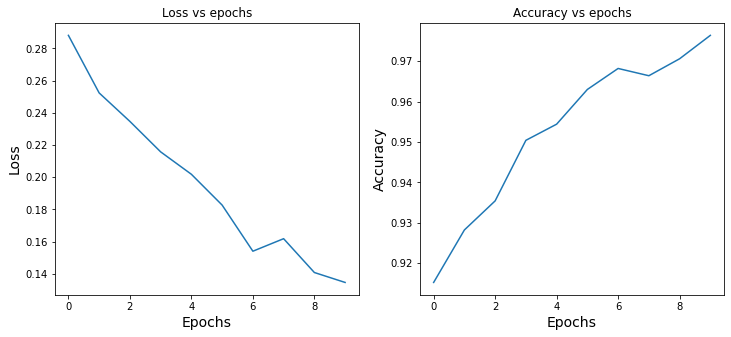

In [16]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(train_loss_results)

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

#### Evaluate the model performance on the test dataset

In [17]:
# Compute the test loss and accuracy

epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

for x, y in test_dataset:
    model_output = resnet_model(x)
    epoch_loss_avg(loss_obj(y, model_output))  
    epoch_accuracy(to_categorical(y), model_output)

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 0.785
Test accuracy: 82.820%


#### Model predictions

Let's see some model predictions! We will randomly select four images from the test data, and display the image and label for each. 

For each test image, model's prediction (the label with maximum probability) is shown, together with a plot showing the model's categorical distribution.

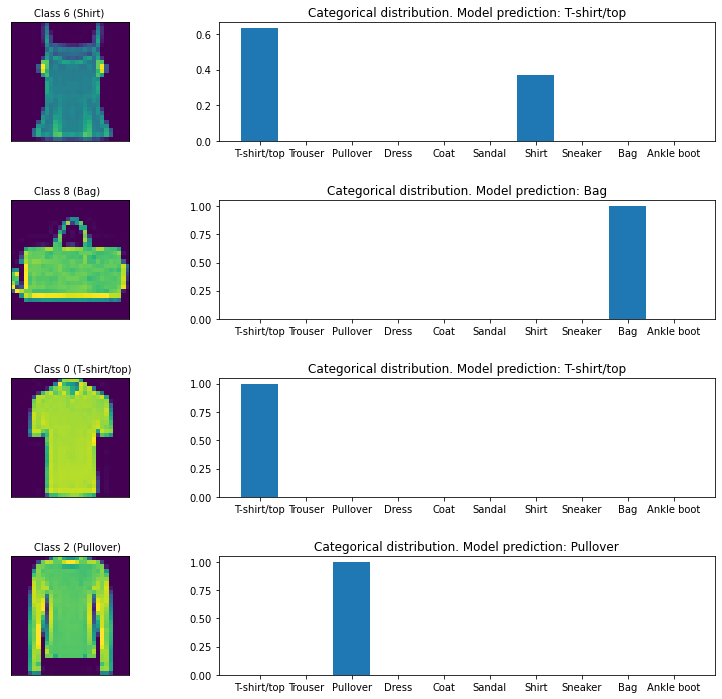

In [18]:
# Run this cell to get model predictions on randomly selected test images

num_test_images = test_images.shape[0]

random_inx = np.random.choice(test_images.shape[0], 4)
random_test_images = test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = resnet_model(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(5., -2., f'Class {label} ({image_labels[label]})')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_xticklabels(image_labels, rotation=0)
    pred_inx = np.argmax(prediction)
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {image_labels[pred_inx]}")
    
plt.show()